# Read sequences and generate geometry/topology

In [1]:
from geometry import *
seq_list,geometry_list,interaction_list,gamma_list,coord_list,\
     bsclist, tsclist, philist = initialize('ahelixtest3.fasta','standard_geometry.str')

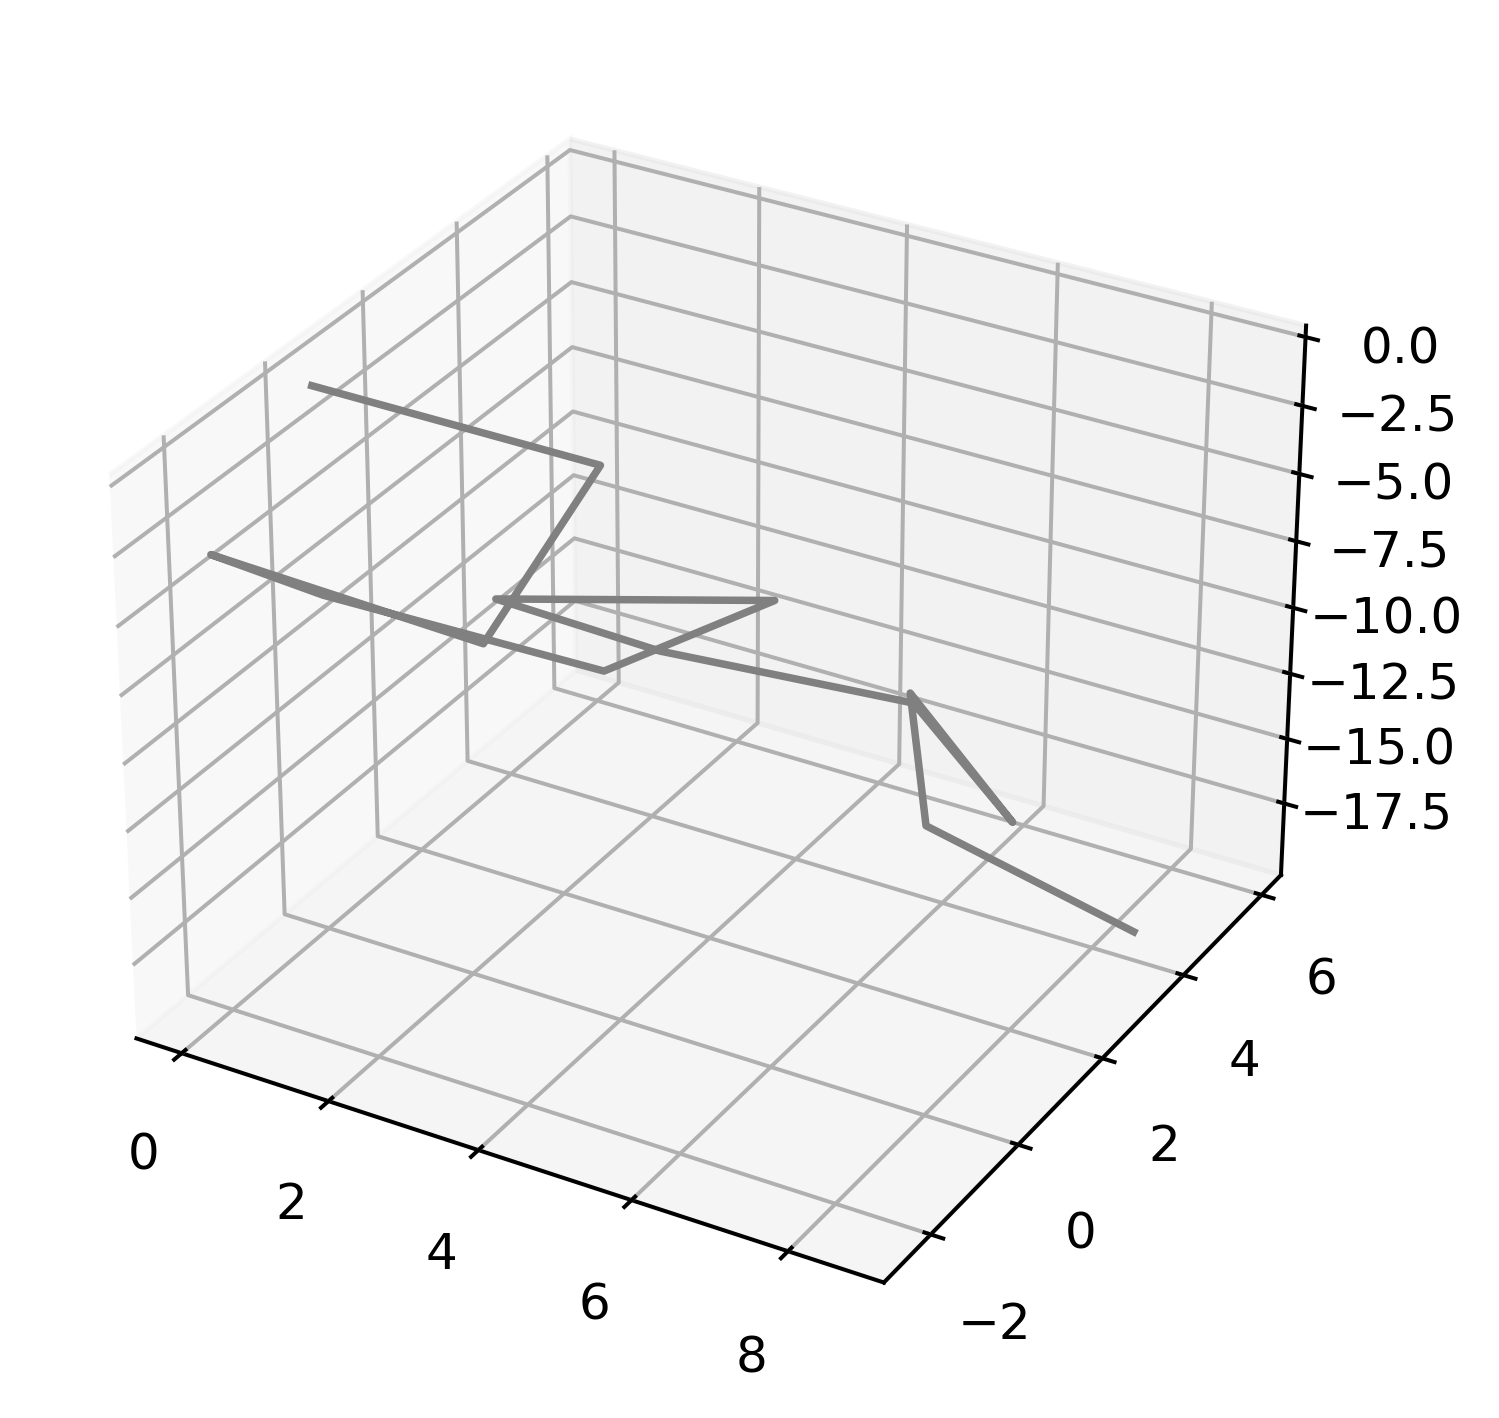

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
coord_list_CA = coord_list[geometry_list == 0]
ax.plot3D(coord_list_CA[:,0], coord_list_CA[:,1], coord_list_CA[:,2], 'gray')
np.savetxt("initiala1.txt",coord_list,fmt = '% 8.3f % 8.3f % 8.3f')

# Run MC simulation

In [3]:
import scipy.stats as ss

def rn_generator(n,st):
    if n%2 != 0:
        m = int(n/2)
        x = np.arange(-m, m+1) 
        xU, xL = x + 0.5, x - 0.5 
        prob = ss.norm.cdf(xU, scale = m) - ss.norm.cdf(xL, scale = m)
        prob = prob / prob.sum() #normalize the probabilities so their sum is 1
        nums = np.random.choice(x, size = st, p = prob) + m
    else:
        m = int(n/2) 
        x = np.arange(-m, m) 
        xU, xL = x + 0.5, x - 0.5 
        prob = ss.norm.cdf(xU, scale = m) - ss.norm.cdf(xL, scale = m)
        prob = prob / prob.sum() #normalize the probabilities so their sum is 1
        nums = np.random.choice(x, size = st, p = prob) + m
    return nums

def classic_calculate_A(beta,delta_pot):
    tmp = np.exp(-delta_pot*beta)
    if tmp >= 1.0:
        return 1.0
    else:
        return tmp
    

In [4]:
def MC_trail(beta, propose_index, gammalist,geometrylist,interactionlist,coord, MJlist, r0ij, rc, \
             bsclist, tsclist, philist,eij_hypho, eij_hyphi,SCPmask,\
             Aij,Bij,rpij,epij,Cabeforelist,Caafterlist,Plist,PPmask, alist_for_link, blist_for_link, old_pot):
    
    trial_move = np.random.normal(0,math.pi/18,1) #(np.random.uniform(0, 1) - 0.5)*2*math.pi/18
    propose_gammalist = np.copy(gammalist)
    propose_gammalist[propose_index] = propose_gammalist[propose_index] + trial_move
    newcoord = transtocoord(propose_gammalist,geometrylist,bsclist,tsclist,philist)
    
    p1 = potential_SCP(interactionlist,newcoord,SCPmask)
    p2 = potential_SCSC(MJlist,r0ij,interactionlist,newcoord,eij_hypho,eij_hyphi,rc)
    p3 = potential_PP(Aij,Bij,rpij,epij,newcoord,Cabeforelist,Caafterlist,Plist,PPmask)
    p4 = potential_torsion(propose_gammalist, alist_for_link, blist_for_link)
    
    new_pot = p2 + p4 + p1 + p3

    A = classic_calculate_A(beta,new_pot - old_pot)
    return propose_gammalist, newcoord, new_pot, A, p1, p2, p3, p4

In [7]:
import time
from potential import *
import numpy as np 

# Start the timer
start_time = time.time()

# Parameters and initialization
rc = 120.0
beta = 1.0 / 0.593  # Corresponds to 298K
total_ts = 50000 * len(gamma_list)  # Total number of timesteps

# Load interaction parameters
MJlist, r0ij, eij_hypho, eij_hyphi = get_SCSC_parameter('parameterMJ.prm', 'r0.prm', interaction_list)
SCPmask = get_SCP_parameter(interaction_list)
Aij, Bij, rpij, epij, Cabeforelist, Caafterlist, Plist, PPmask = get_PP_parameter(interaction_list, 'parameterpp.prm')
alist_for_link, blist_for_link = get_torsion_parameter('parametertorsion.prm', interaction_list, geometry_list)

# Initialize records for simulation
record_coord = [coord_list]
record_gamma = [gamma_list]
record_energy = []
record_P1, record_P2, record_P3, record_P4 = [], [], [], []

# Calculate initial potentials
p1 = potential_SCP(interaction_list, coord_list, SCPmask)
p2 = potential_SCSC(MJlist, r0ij, interaction_list, coord_list, eij_hypho, eij_hyphi, rc)
p3 = potential_PP(Aij, Bij, rpij, epij, coord_list, Cabeforelist, Caafterlist, Plist, PPmask)
p4 = potential_torsion(gamma_list, alist_for_link, blist_for_link)

oldpot = p1 + p2 + p3 + p4

# Record initial state
record_energy.append(oldpot)
record_P1.append(p1)
record_P2.append(p2)
record_P3.append(p3)
record_P4.append(p4)

# Monte Carlo simulation
acceptance = 0
for ts in range(50000):
    for i in range(len(gamma_list)):
        # Perform a Monte Carlo trial
        newgammalist, newpos, newpot, A, pp1, pp2, pp3, pp4 = MC_trail(
            beta, i, gamma_list, geometry_list, interaction_list, coord_list,
            MJlist, r0ij, rc, bsclist, tsclist, philist, eij_hypho, eij_hyphi,
            SCPmask, Aij, Bij, rpij, epij, Cabeforelist, Caafterlist, Plist,
            PPmask, alist_for_link, blist_for_link, oldpot
        )

        # Accept or reject the trial move
        if np.random.random_sample() < A:
            gamma_list = newgammalist
            coord_list = newpos
            oldpot = newpot
            p1, p2, p3, p4 = pp1, pp2, pp3, pp4
            acceptance += 1

    # Record data every 10 timesteps
    if ts % 10 == 0:
        record_coord.append(coord_list)
        record_gamma.append(gamma_list)
        record_energy.append(oldpot)
        record_P1.append(p1)
        record_P2.append(p2)
        record_P3.append(p3)
        record_P4.append(p4)

    # Log progress every 100 timesteps
    if ts % 100 == 0:
        elapsed_time = time.time() - start_time
        print(f"--- {ts} steps in {elapsed_time:.2f} seconds ---")
        print(f"Current potential: {oldpot}")

# Final summary
print(f"Acceptance ratio: {acceptance / total_ts:.2%}")


(12, 11)
--- 0 steps in 0.06 seconds ---
Current potential: -36.870991338899444


/tmp/ipykernel_391542/4196520600.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  propose_gammalist[propose_index] = propose_gammalist[propose_index] + trial_move


--- 100 steps in 4.53 seconds ---
Current potential: -36.33050658288943
--- 200 steps in 8.99 seconds ---
Current potential: -35.508419230884286
--- 300 steps in 13.46 seconds ---
Current potential: -34.29127362291842
--- 400 steps in 17.94 seconds ---
Current potential: -34.77985560414649
--- 500 steps in 22.38 seconds ---
Current potential: -34.93608272527875
--- 600 steps in 26.90 seconds ---
Current potential: -34.2368047839924
--- 700 steps in 31.34 seconds ---
Current potential: -34.550652548715895
--- 800 steps in 35.85 seconds ---
Current potential: -34.51464779435105
--- 900 steps in 40.43 seconds ---
Current potential: -37.005436694954284
--- 1000 steps in 45.06 seconds ---
Current potential: -36.1422231591427
--- 1100 steps in 50.17 seconds ---
Current potential: -35.8569808688038
--- 1200 steps in 54.70 seconds ---
Current potential: -35.40302751658787
--- 1300 steps in 59.23 seconds ---
Current potential: -30.618204427249267
--- 1400 steps in 63.66 seconds ---
Current pote

--- 11100 steps in 497.75 seconds ---
Current potential: -34.55790925530712
--- 11200 steps in 502.19 seconds ---
Current potential: -33.39333377921828
--- 11300 steps in 506.63 seconds ---
Current potential: -35.60748823360866
--- 11400 steps in 511.07 seconds ---
Current potential: -36.82716522240342
--- 11500 steps in 515.49 seconds ---
Current potential: -37.986393131165606
--- 11600 steps in 519.93 seconds ---
Current potential: -33.41131053015196
--- 11700 steps in 524.38 seconds ---
Current potential: -34.3531142839294
--- 11800 steps in 528.82 seconds ---
Current potential: -36.690338603222386
--- 11900 steps in 533.24 seconds ---
Current potential: -36.702687889113214
--- 12000 steps in 537.77 seconds ---
Current potential: -34.224776074574464
--- 12100 steps in 542.17 seconds ---
Current potential: -33.468040009583405
--- 12200 steps in 546.61 seconds ---
Current potential: -34.07368542986379
--- 12300 steps in 551.30 seconds ---
Current potential: -31.86210933666313
--- 1240

--- 21900 steps in 985.17 seconds ---
Current potential: -36.08990180500975
--- 22000 steps in 989.60 seconds ---
Current potential: -34.84104338846153
--- 22100 steps in 994.04 seconds ---
Current potential: -37.62991487930111
--- 22200 steps in 998.50 seconds ---
Current potential: -36.722097794244135
--- 22300 steps in 1003.00 seconds ---
Current potential: -31.217657386103063
--- 22400 steps in 1007.40 seconds ---
Current potential: -32.008159847778074
--- 22500 steps in 1011.89 seconds ---
Current potential: -27.394094641433952
--- 22600 steps in 1016.47 seconds ---
Current potential: -34.81009866068076
--- 22700 steps in 1021.08 seconds ---
Current potential: -37.07903557931386
--- 22800 steps in 1025.67 seconds ---
Current potential: -35.03003286716702
--- 22900 steps in 1030.29 seconds ---
Current potential: -31.647171061011765
--- 23000 steps in 1034.77 seconds ---
Current potential: -36.41452124978278
--- 23100 steps in 1039.20 seconds ---
Current potential: -33.0858771123732

--- 32500 steps in 1457.25 seconds ---
Current potential: -36.787372629519794
--- 32600 steps in 1461.65 seconds ---
Current potential: -34.358400860616484
--- 32700 steps in 1466.06 seconds ---
Current potential: -37.360715534821026
--- 32800 steps in 1470.56 seconds ---
Current potential: -38.50858630458204
--- 32900 steps in 1474.96 seconds ---
Current potential: -35.33333398489388
--- 33000 steps in 1479.44 seconds ---
Current potential: -34.62597347926287
--- 33100 steps in 1483.90 seconds ---
Current potential: -32.72184027213382
--- 33200 steps in 1488.34 seconds ---
Current potential: -34.303136078642915
--- 33300 steps in 1492.73 seconds ---
Current potential: -36.15802260107151
--- 33400 steps in 1497.16 seconds ---
Current potential: -31.51760065095008
--- 33500 steps in 1501.57 seconds ---
Current potential: -34.144847314652
--- 33600 steps in 1505.98 seconds ---
Current potential: -34.86191079350076
--- 33700 steps in 1510.36 seconds ---
Current potential: -32.525074904020

--- 43200 steps in 1929.19 seconds ---
Current potential: -34.63776442896169
--- 43300 steps in 1933.66 seconds ---
Current potential: -34.43220061229845
--- 43400 steps in 1938.07 seconds ---
Current potential: -32.58866767150943
--- 43500 steps in 1942.46 seconds ---
Current potential: -33.68853977803811
--- 43600 steps in 1946.90 seconds ---
Current potential: -34.19836803789314
--- 43700 steps in 1951.33 seconds ---
Current potential: -33.72340322735926
--- 43800 steps in 1955.74 seconds ---
Current potential: -31.852455341524312
--- 43900 steps in 1960.22 seconds ---
Current potential: -36.242718876078705
--- 44000 steps in 1964.67 seconds ---
Current potential: -31.97162133393693
--- 44100 steps in 1969.14 seconds ---
Current potential: -31.161491792518884
--- 44200 steps in 1973.53 seconds ---
Current potential: -35.65122118341182
--- 44300 steps in 1977.96 seconds ---
Current potential: -33.53014593157954
--- 44400 steps in 1982.47 seconds ---
Current potential: -31.74330295627

# Save trajectory/plot potential

In [8]:
min_energy_index = np.where(record_energy == np.min(record_energy))[0]
np.save('record_coorda1.npy', record_coord)
np.save('record_gammaa1.npy', record_gamma)
np.save('record_energy.npy', record_energy)
np.save('record_p1.npy',record_P1)
np.save('record_p2.npy',record_P2)
np.save('record_p3.npy',record_P3)
np.save('record_p4.npy',record_P4)

In [9]:
min_energy_index = np.where(record_energy == np.min(record_energy))[0][0]
print(min_energy_index)
coord_with_min_energy = record_coord[min_energy_index]
np.savetxt("structurea1.txt",coord_with_min_energy,fmt = '% 8.3f % 8.3f % 8.3f')
coord_initial = record_coord[0]
np.savetxt("initiala1.txt",coord_initial,fmt = '% 8.3f % 8.3f % 8.3f')

3739


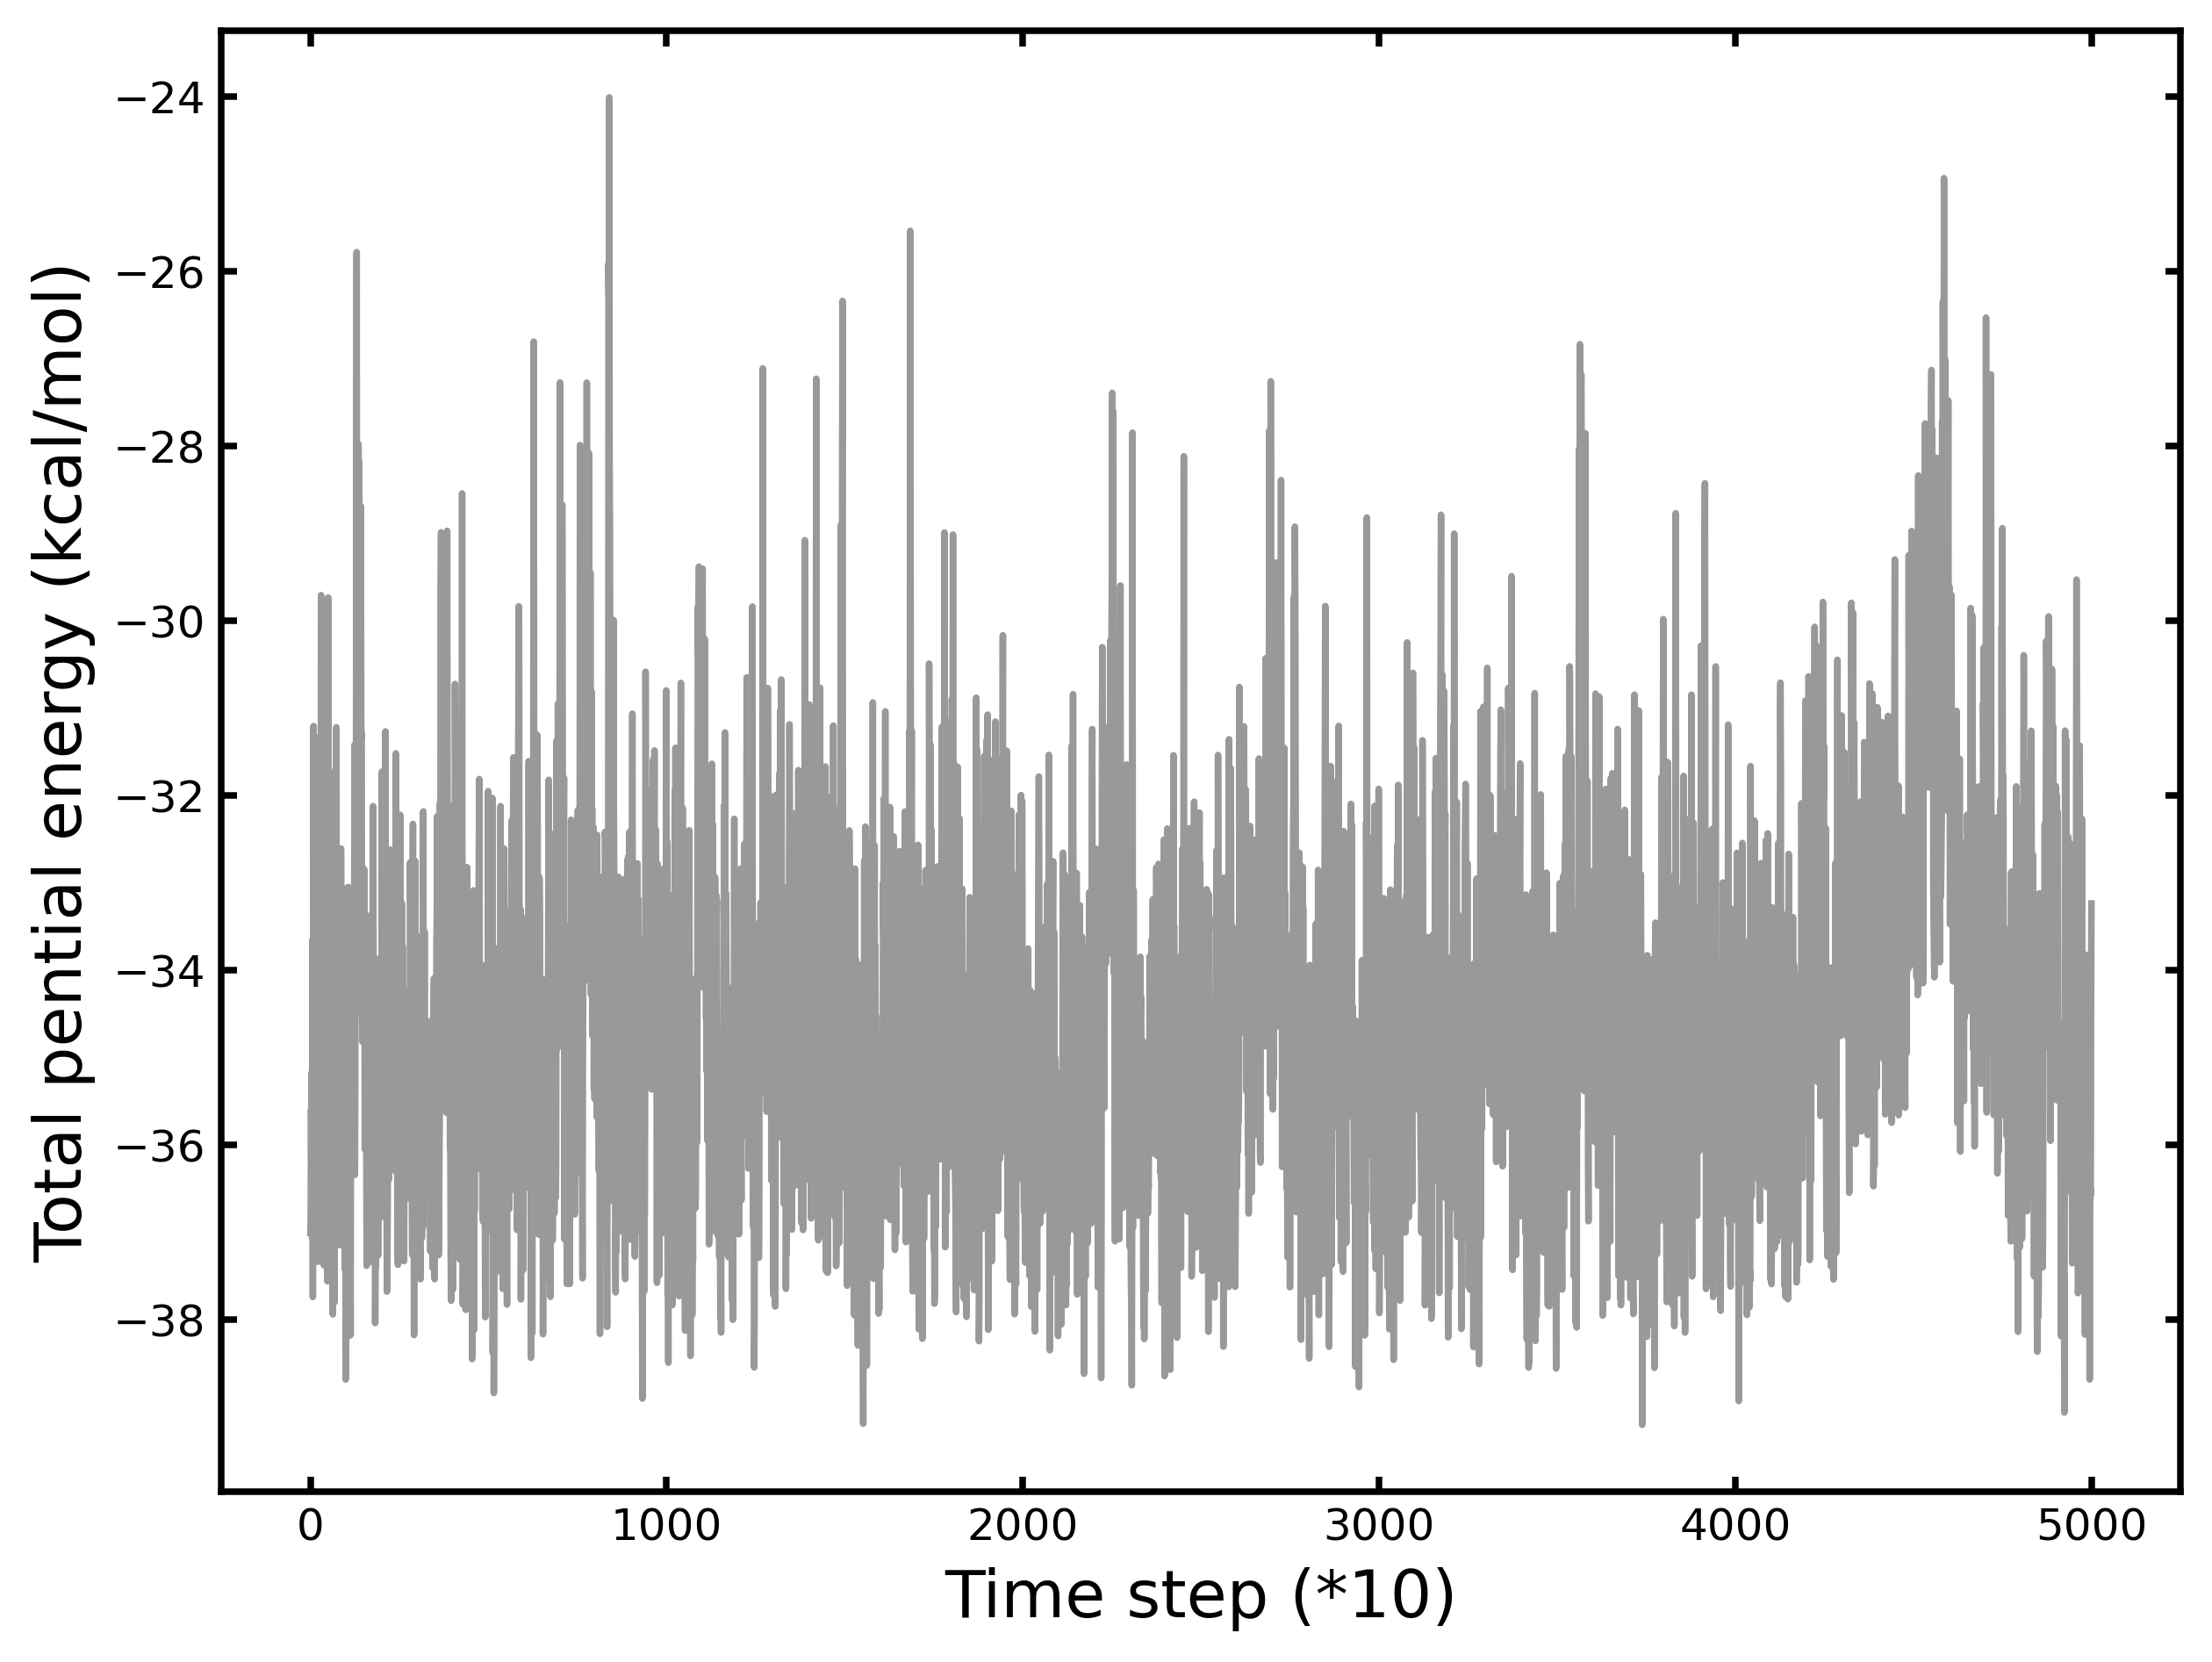

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.tick_params(which='both',top='on',left = 'on', right = 'on', bottom ='on',direction='in',width = 1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
#plt.ylim([-40,-10])
plt.plot(record_energy,alpha = 0.4, color = 'k')
plt.xlabel('Time step (*10)',fontsize = 15)
plt.ylabel("Total pential energy (kcal/mol)", fontsize = 15)
plt.savefig('figure2.1.pdf')

In [12]:
def my_var(dataset):
    n = len(dataset)
    ave = np.mean(dataset)
    var = np.sum((dataset-ave)**2)
    var = var/(n-1)
    return var
def coeff(s,lag):
    n = len(s)
    ave = np.mean(s)
    tmp1 = np.array(s[0:n-lag])-ave
    tmp2 = np.array(s[lag:n])-ave
    v = my_var(s)
    return np.dot(tmp1,tmp2)/((n-lag)*v)
def my_actime(a): 
    lags = range(1,len(a)) 
    corrs = []
    tmp = 0
    for i in lags:
        tmp = coeff(a,i)
        corrs.append(tmp)
    indices = [idx for idx,val in enumerate(corrs) if val < 0]
    corr_t = 1+2*np.sum(corrs[0:indices[0]])
    return lags, corrs, corr_t

In [13]:
valid_record_energy = record_energy[500:]
lags, corrs, corr_t = my_actime(np.array(valid_record_energy))
print("auto correlation time = ",corr_t)
error_estimate = np.sqrt(corr_t*my_var(np.array(valid_record_energy))/len(valid_record_energy))
print("error estimation = ", error_estimate)

auto correlation time =  39.137264762252926
error estimation =  0.1889679337252243


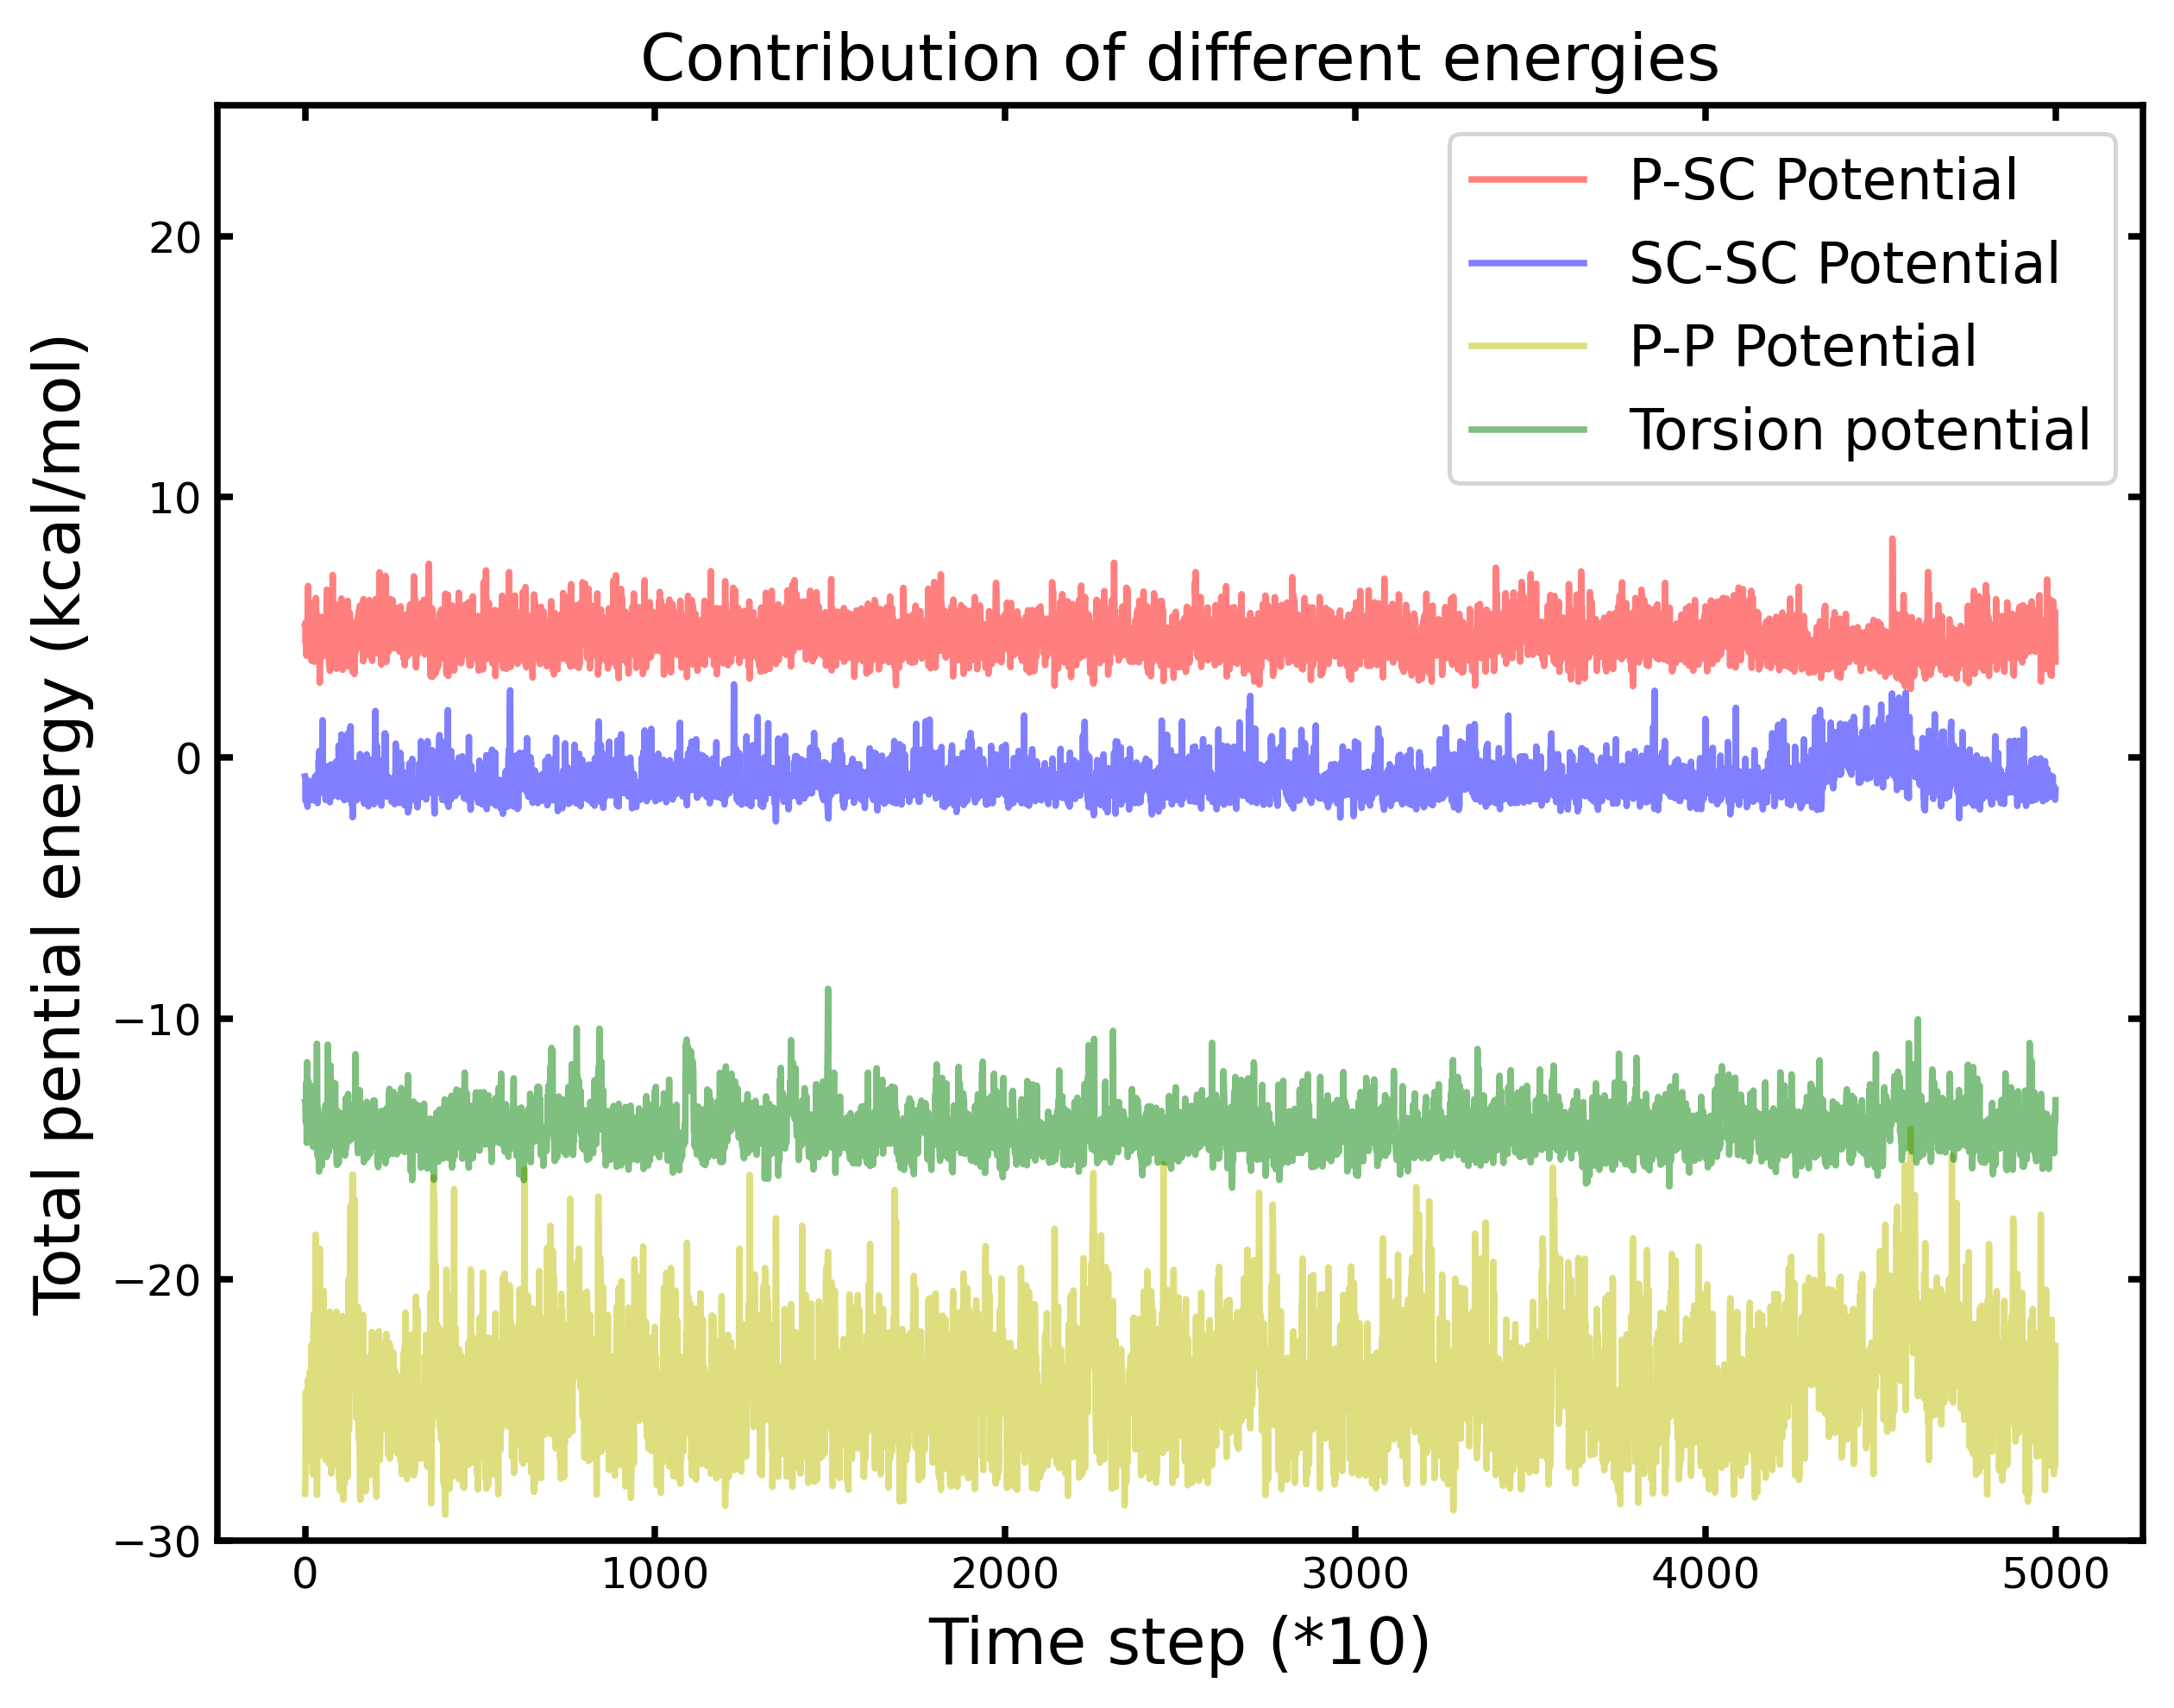

In [14]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.tick_params(which='both',top='on',left = 'on', right = 'on', bottom ='on',direction='in',width = 1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
#plt.plot(record_energy,alpha = 0.4, color = 'k')
plt.plot(record_P1,alpha = 0.5, color = 'r', label = 'P-SC Potential')
plt.plot(record_P2,alpha = 0.5, color = 'b', label = 'SC-SC Potential')
plt.plot(record_P3,alpha = 0.5, color = 'y', label = 'P-P Potential')
plt.plot(record_P4,alpha = 0.5, color = 'g', label = 'Torsion potential')
plt.xlabel('Time step (*10)',fontsize = 15)
plt.ylabel("Total pential energy (kcal/mol)", fontsize = 15)
plt.legend(fontsize = 13,loc = 'best')
plt.ylim([-30,25])
plt.title('Contribution of different energies', fontsize = 15)
plt.savefig('figure2.3.pdf')
